In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
import dipy.reconst.sfm as sfm
import dipy.reconst.csdeconv as csd
import dipy.reconst.dti as dti
import dipy.core.gradients as grad

In [3]:
import utils

In [4]:
data = utils.read_data()

In [60]:
train_data = data['seen']['signal'][:, 0][::2]
train_bvals = data['seen']['bvals'][::2]
train_bvecs = data['seen']['bvecs'][::2]
train_delta = data['seen']['delta'][::2]
train_Delta = data['seen']['Delta'][::2]
train_te = data['seen']['TE'][::2]

test_data = data['seen']['signal'][:, 0][1::2]
test_bvals = data['seen']['bvals'][1::2]
test_bvecs = data['seen']['bvecs'][1::2]
test_delta = data['seen']['delta'][1::2]
test_Delta = data['seen']['Delta'][1::2]
test_te = data['seen']['TE'][1::2]


In [74]:
train_gtab = grad.gradient_table(train_bvals, train_bvecs, big_delta=train_Delta, small_delta=train_delta)
test_gtab = grad.gradient_table(test_bvals, test_bvecs, big_delta=test_Delta, small_delta=test_delta)

In [75]:
train_s0 = train_data[train_gtab.b0s_mask]

In [95]:
p = np.polyfit(train_te[train_gtab.b0s_mask], np.log(train_data[train_gtab.b0s_mask]), 3)

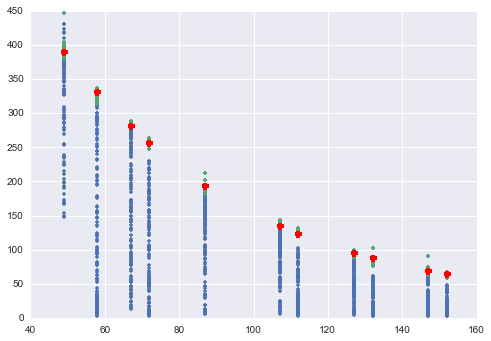

In [96]:
plt.plot(train_te, train_data, '.')
plt.plot(train_te[train_gtab.b0s_mask], train_data[train_gtab.b0s_mask], '.')
pred_lin = np.polyval(p, train_te)
plt.plot(train_te, np.exp(pred_lin), 'ro')

In [97]:
train_data_no_te = np.zeros_like(train_data)

In [98]:
this_te

152.0

In [99]:
np.polyval(p, this_te)

4.1596754085204868

In [100]:
for ii in range(train_data_no_te.shape[0]):
    this_te = train_te[ii]
    te_idx = (train_te==this_te)
    te_s0 = np.mean(train_data[te_idx * train_gtab.b0s_mask])
    te_est = np.exp(np.polyval(p, this_te))
    train_data_no_te[ii] = train_data[ii]/te_est
    

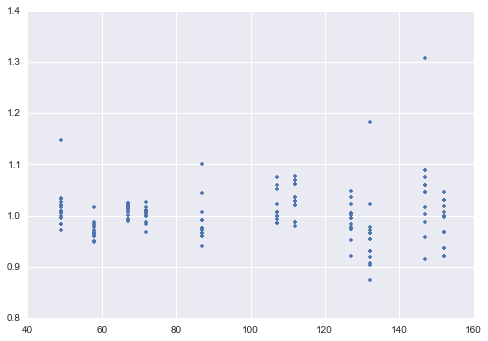

In [101]:
plt.plot(train_te[train_gtab.b0s_mask], train_data_no_te[train_gtab.b0s_mask], '.')

In [102]:
model = sfm.SparseFascicleModel(train_gtab, isotropic=sfm.ExponentialIsotropicModel)
#model = dti.TensorModel(train_gtab)

In [103]:
fit = model.fit(train_data_no_te)

In [104]:
predict = fit.predict(test_gtab)

In [105]:
predict_with_te = np.zeros_like(predict)

In [106]:
for ii in range(predict_with_te.shape[0]):
    #this_te = train_te[ii]
    #te_idx = (train_te==this_te)
    #te_s0 = np.mean(train_data[te_idx * train_gtab.b0s_mask])
    #predict_with_te[ii] = predict[ii] * te_s0
    
    this_te = train_te[ii]
    te_idx = (train_te==this_te)
    te_est = np.exp(np.polyval(p, this_te))
    predict_with_te[ii] = predict[ii] * te_est

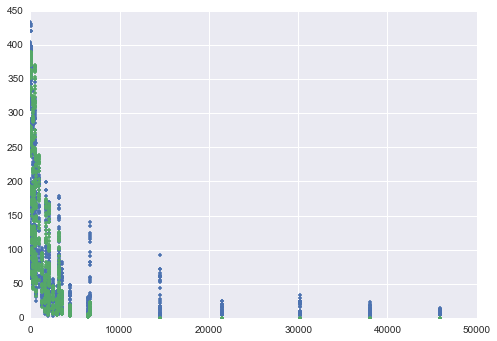

In [107]:
plt.plot(test_gtab.bvals, test_data, '.')
plt.plot(test_gtab.bvals, predict_with_te, '.')

In [108]:
def LSE(prediction, signal, sigma=8):
    return np.mean(((prediction - np.sqrt(signal**2 + sigma**2))**2)/(sigma**2))

In [109]:
LSE(predict_with_te, test_data)

6.7484798670721702

In [110]:
LSE(np.ones_like(train_data) * np.mean(train_data), train_data)

179.96553385160149

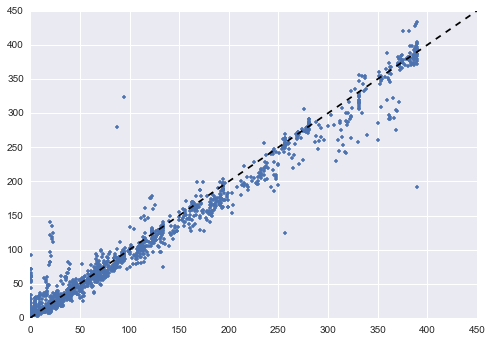

In [111]:
plt.plot(predict_with_te, test_data, '.')
plt.plot([0, 450], [0, 450], 'k--')